У цьому ДЗ ми попрактикуємось моделювати часові ряди на даних з [Store Item Demand Forecasting Challenge](https://www.kaggle.com/competitions/demand-forecasting-kernels-only/overview). Ми будемо працювати лише з тренувальними даними цього змагання і задача у нас буде дещо змінена. Фокус буде на пошуці найкращої моделі, експериментах і використанні функціоналу `darts`.

Якщо якісно попрацювати в цьому завданні - це буде чудовий приклад проєкту для вашого портфоліо: "спрогнозував(-ла) поденні продажі на 1 міс для 50 товарів в 10 магазинах" звучить вражаюче! Але ми в рамках ДЗ для оптимізації часу сконцентруємось на моделюванні продажів одного товару в одному магазині.

**Задача**

Вам надано дані про продажі товарів у магазинах за 5 років. Хочемо навчитись передбачати продажі в наступному місяці поденно кожного з 50 товарів у кожному з 10 магазинів. Відповідно будемо проводити експерименти, аби знайти найкращу модель для цього.

На відміну від змагання, ми будемо використовувати метрику МАРЕ (Mean Absolute Percentage Error) замість SMAPE (Symmetric Mean Absolute Percentage Error). Проте, ви також можете розрахувати SMAPE і подати свої результати через late submission на Kaggle.

## Imports

In [ ]:
! pip install pytorch-lightning "u8darts[notorch]" --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.2/57.2 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.6/169.6 kB 7.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 819.3/819.3 kB 27.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 82.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 354.4/354.4 kB 29.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 77.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 59.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 39.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from darts import TimeSeries, concatenate
from darts.dataprocessing.transformers import Scaler
from darts.metrics import mape, rmse
from darts.models import (NaiveSeasonal, NaiveDrift,
                          XGBModel, ExponentialSmoothing,
                          ARIMA, AutoARIMA,
                          Prophet, RNNModel)
from darts.utils.statistics import check_seasonality, plot_hist
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_absolute_percentage_error

# Set default plot parameters (were overwritten by darts)
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams['figure.figsize'] = (10, 4)

import torch
torch.manual_seed(42)

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Suppress cmdstanpy logs
import logging
logging.getLogger("cmdstanpy").disabled = True

## 1. Load the data

Завантажуємо дані в Pandas.

  1. Завантажте дані з файлу `train.csv.zip` за допомогою бібліотеки Pandas.
  2. Перетворіть колонку `date` на формат `datetime`.
  3. Встановіть колонку `date` як індекс для датафрейму.
  4. Виведіть перші 10 рядків отриманого датафрейму та інформацію про датафрейм.

In [ ]:
raw_df = pd.read_csv('time_series_train.csv.zip')
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   date    913000 non-null  object
 1   store   913000 non-null  int64 
 2   item    913000 non-null  int64 
 3   sales   913000 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 27.9+ MB


In [ ]:
raw_df['date'] = pd.to_datetime(raw_df['date'])

In [ ]:
data = raw_df.copy(deep=True)
data.set_index('date', inplace=True)

In [ ]:
display(data.head(10))
data.describe()

store  item  sales
date                          
2013-01-01      1     1     13
2013-01-02      1     1     11
2013-01-03      1     1     14
2013-01-04      1     1     13
2013-01-05      1     1     10
2013-01-06      1     1     12
2013-01-07      1     1     10
2013-01-08      1     1      9
2013-01-09      1     1     12
2013-01-10      1     1      9

store           item          sales
count  913000.000000  913000.000000  913000.000000
mean        5.500000      25.500000      52.250287
std         2.872283      14.430878      28.801144
min         1.000000       1.000000       0.000000
25%         3.000000      13.000000      30.000000
50%         5.500000      25.500000      47.000000
75%         8.000000      38.000000      70.000000
max        10.000000      50.000000     231.000000

## 2. Understanding the data
Давайте трошки зрозуміємо дані. У нас 10 магазинів і 50 айтемів в кожному. Хочемо зрозуміти, чи відрізняється динаміка по кожному айтему в магазинах. Як би ви це візуалізували? Побудуйте 3 графіка, які вам допоможуть. Можна використати будь-який інструмент: matplotlib, seaborn, plotly.

  Напишіть висновок з побудованих вами візуалізацій.
  
    **Підказка**: я б спробувала вивести середнє значення і довірчий інтервал (який включає весь діапазон значень з різних магазинів) для динаміки кожного айтема, або принаймні для декількох айтемів, аби зрозуміти тенденцію.



Resamples time series data by a given frequency and computes 95% confidence interval for the mean sales.


In [ ]:
def create_resample_summary(df, frequency: str):
    summary = df.groupby('item').resample(frequency).agg(
        mean_sales=('sales', 'mean'),
        std_sales=('sales', 'std'),
        n_sales=('sales', 'count')
    )
    summary['se'] = summary['std_sales'] / np.sqrt(summary['n_sales'])

    summary['ci_lower'] = summary['mean_sales'] - 1.96* summary['se']
    summary['ci_upper'] = summary['mean_sales'] + 1.96* summary['se']
    summary.reset_index(inplace=True)
    return summary

In [ ]:
summary = create_resample_summary(data, frequency='W')
summary.head()

item       date  mean_sales  std_sales  n_sales        se   ci_lower  \
0     1 2013-01-06   13.366667   4.850185       60  0.626156  12.139401   
1     1 2013-01-13   12.328571   4.927655       70  0.588967  11.174195   
2     1 2013-01-20   12.357143   4.488425       70  0.536469  11.305663   
3     1 2013-01-27   11.414286   4.123081       70  0.492802  10.448393   
4     1 2013-02-03   13.628571   5.022187       70  0.600266  12.452050   

    ci_upper  
0  14.593933  
1  13.482948  
2  13.408623  
3  12.380178  
4  14.805093

Plot sales dynamics for some item by store with mean values and confidence interval across all stores.

In [ ]:
def lineplot_with_ci(data, items, stores, frequency='W'):
    sales_max = 0
    _, ax = plt.subplots(len(items), figsize=(12, 7))

    for i, item in enumerate(items):
        summary = create_resample_summary(data, frequency)
        temp_summary = summary[summary['item'] == item]

        for store in stores:
            series = (data[(data.item == item) & (data.store == store)]['sales']
                    .resample(frequency).mean())
            if series.max() > sales_max:
                sales_max = series.max()
            sns.lineplot(series, ax=ax[i], label=f'Store {store}')

            ax[i].set_title(f'Item {item}')

        ax[i].fill_between(temp_summary['date'],
                           temp_summary['ci_lower'],
                           temp_summary['ci_upper'],
                           alpha=0.7,
                           color='tan',
                           label='confidence interval')
        ax[i].legend()

    for axis in ax:
        axis.set_ylim(top=sales_max+2)

    plt.tight_layout()
    plt.show()

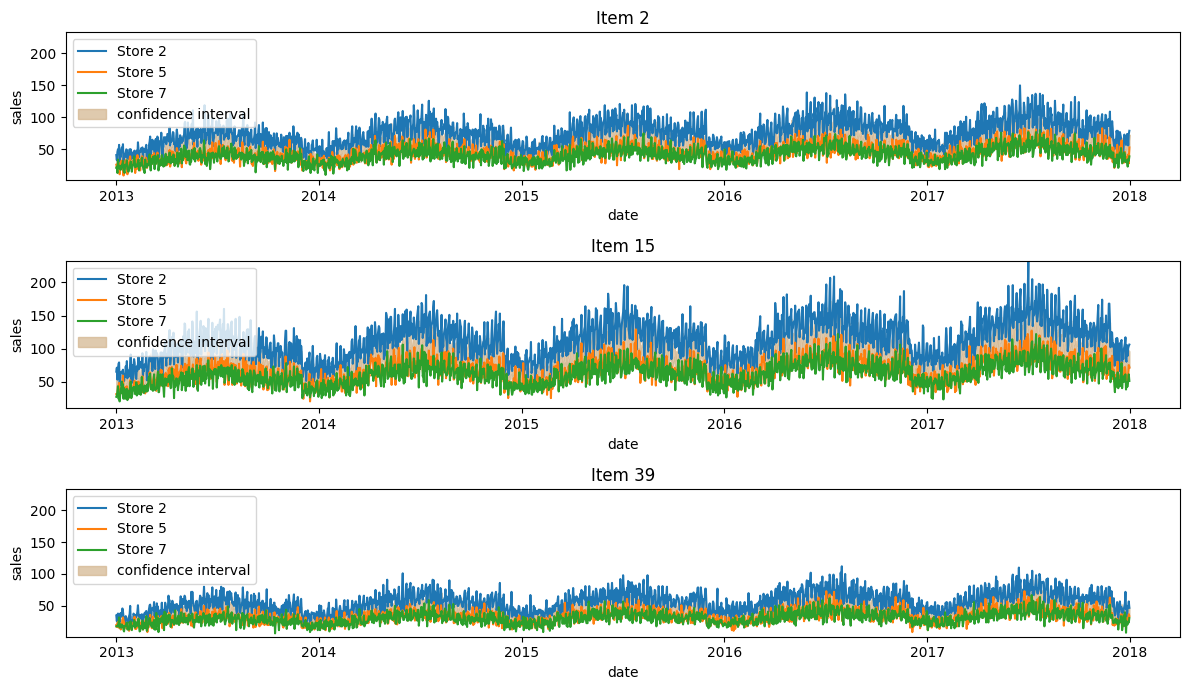

In [ ]:
items = [2, 15, 39]
stores = [2, 5, 7]
lineplot_with_ci(data, items, stores, frequency='D')

With weekly frequencies:

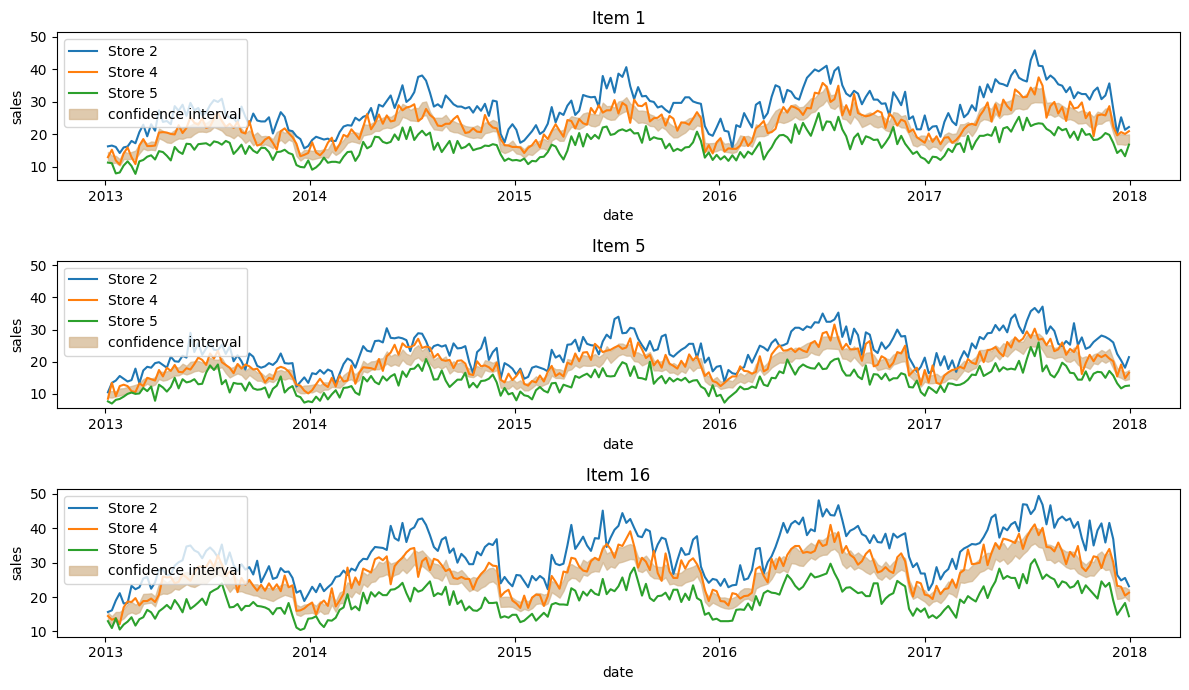

In [ ]:
items = [1, 5, 16]
stores = [2, 4, 5]
lineplot_with_ci(data, items, stores, frequency='W')

We can observe:
- Sales dynamics exhibit possible weekly and monthly patterns and clear yearly seasonality across all stores and items.
- Sales of different items vary across different stores.
- Sales tend to increase over the years.

In [ ]:
data_df_mean = data.groupby(by=['store', 'item'])['sales'].mean().unstack()
data_df_mean.round(2)

item      1      2      3      4      5      6      7      8      9      10  \
store                                                                         
1      19.97  53.15  33.21  19.96  16.61  53.06  52.78  69.47  46.50  66.35   
2      28.17  75.32  46.99  28.23  23.54  74.95  75.06  99.09  65.48  94.10   
3      25.07  66.80  41.77  25.12  20.86  67.01  66.65  87.52  58.49  83.39   
4      22.94  61.72  38.55  23.09  19.53  61.27  61.63  80.82  54.04  77.05   
5      16.74  44.49  27.84  16.78  14.09  44.56  44.54  58.57  38.84  55.51   
6      16.72  44.53  27.81  16.75  13.89  44.50  44.60  58.39  39.46  55.57   
7      15.16  40.72  25.53  15.36  12.73  40.70  40.71  53.72  35.90  51.16   
8      26.98  71.66  45.08  26.95  22.43  71.96  71.73  94.46  63.19  89.82   
9      23.33  61.79  38.54  23.15  19.27  61.41  61.81  81.29  54.11  77.11   
10     24.74  65.57  41.11  24.72  20.64  65.61  65.81  86.18  57.89  82.23   

item   ...     41     42     43     44      45     46     47     48     49  \
store  ...                                                                   
1      ...  20.00  33.11  46.24  26.59   72.72  52.85  19.81  46.55  26.46   
2      ...  28.07  47.37  65.79  37.79  103.38  75.22  28.19  66.03  37.71   
3      ...  24.99  41.80  58.20  33.39   91.85  66.75  25.12  58.70  33.26   
4      ...  23.17  38.54  54.02  30.95   84.69  61.42  23.11  53.77  30.84   
5      ...  16.83  27.73  39.16  22.42   61.43  44.73  16.70  39.28  22.37   
6      ...  16.61  27.89  39.03  22.32   61.14  44.54  16.71  39.05  22.18   
7      ...  15.47  25.44  35.43  20.45   55.91  40.83  15.48  35.62  20.41   
8      ...  27.04  45.14  62.98  36.19   98.94  72.00  27.15  62.74  36.04   
9      ...  23.19  38.64  54.15  30.97   85.09  62.01  23.00  53.98  31.05   
10     ...  24.65  41.22  57.94  32.92   90.69  66.05  24.76  57.81  33.03   

item      50  
store         
1      59.34  
2      84.62  
3      74.96  
4      68.92  
5      50.32  
6      50.52  
7      45.82  
8      80.97  
9      69.31  
10     74.04  

[10 rows x 50 columns]

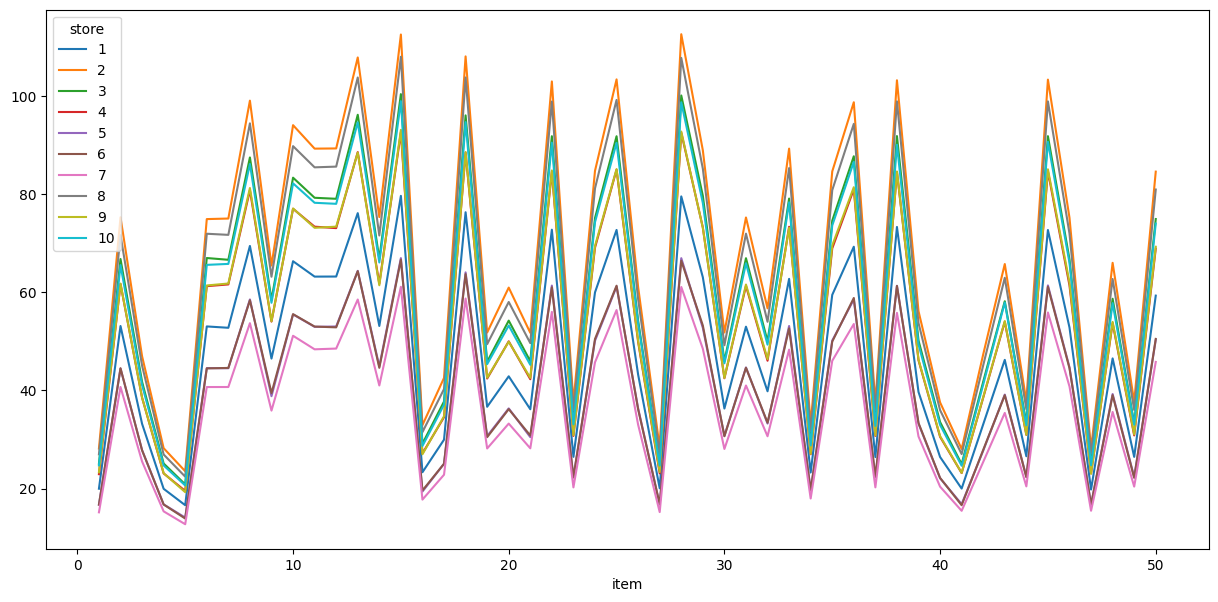

In [ ]:
data_df_mean.T.plot(figsize=(15,7))
plt.show()

The average values of sales for each of 50 items vary by store.

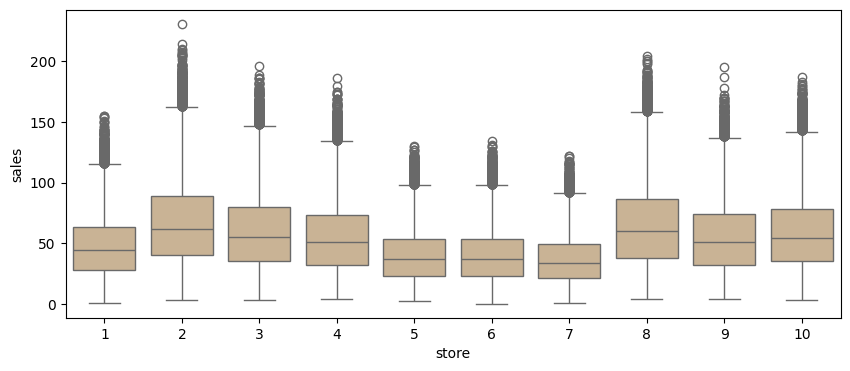

In [ ]:
sns.boxplot(data, x='store', y='sales', color='tan')
plt.show()

Sales distribution varies by store (store 2 and 8 have the highest sales, 5, 6 and 7 - the lowest sales.)

## 3. Analyze the one series
**Для початку проаналізуємо лише один ряд, а далі зможемо зациклити тренування моделей.**
  
  Виберіть підмножину даних, що відповідає продажам товару з `item == 1` у магазині з `store == 1`.

  Зробіть декомпозицію цього рядку за адитивною моделлю на тренд, сезонність і залишки з бібліотекою `statsmodels`.

  Зробіть висновки з отриманих візуалізацій. Чи щось би могло вам допомогти ліпше зрозуміти ці візуалізації? (з точки зору обробки даних)

In [ ]:
# item 1 and store 1
df_one = (data[(data.item == 1) & (data.store == 1)])[['sales']]
df_one.head()

sales
date             
2013-01-01     13
2013-01-02     11
2013-01-03     14
2013-01-04     13
2013-01-05     10

In [ ]:
fig = px.line(df_one, y='sales')
fig.update_layout(template='simple_white',
                  title_text='Sales Dynamic of Item 1 in Store 1',
                  title_x=0.5)

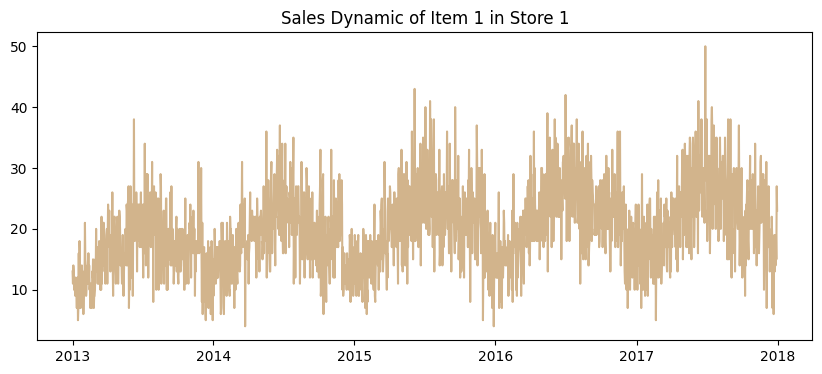

In [ ]:
plt.plot(df_one, color='tan')
plt.title('Sales Dynamic of Item 1 in Store 1')
plt.show()

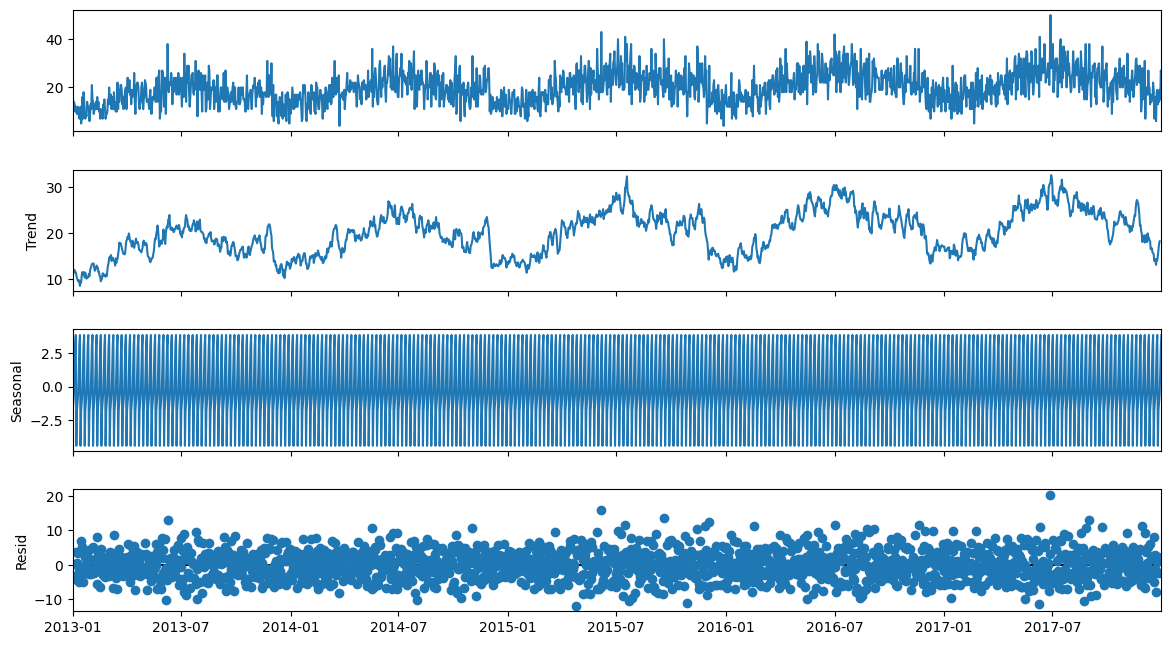

In [ ]:
decomposed = seasonal_decompose(df_one, model='additive')
fig = decomposed.plot()
fig.set_size_inches((12, 7))
plt.show()

`seasonal_decompose` from `statmodels` capture weekly seasonality, but it seems like there is also year seasonality.

The residuals fluctuate around zero but range from -10 to 10, while the actual values range from 0 to 40, indicating that the residuals have relatively hight values.

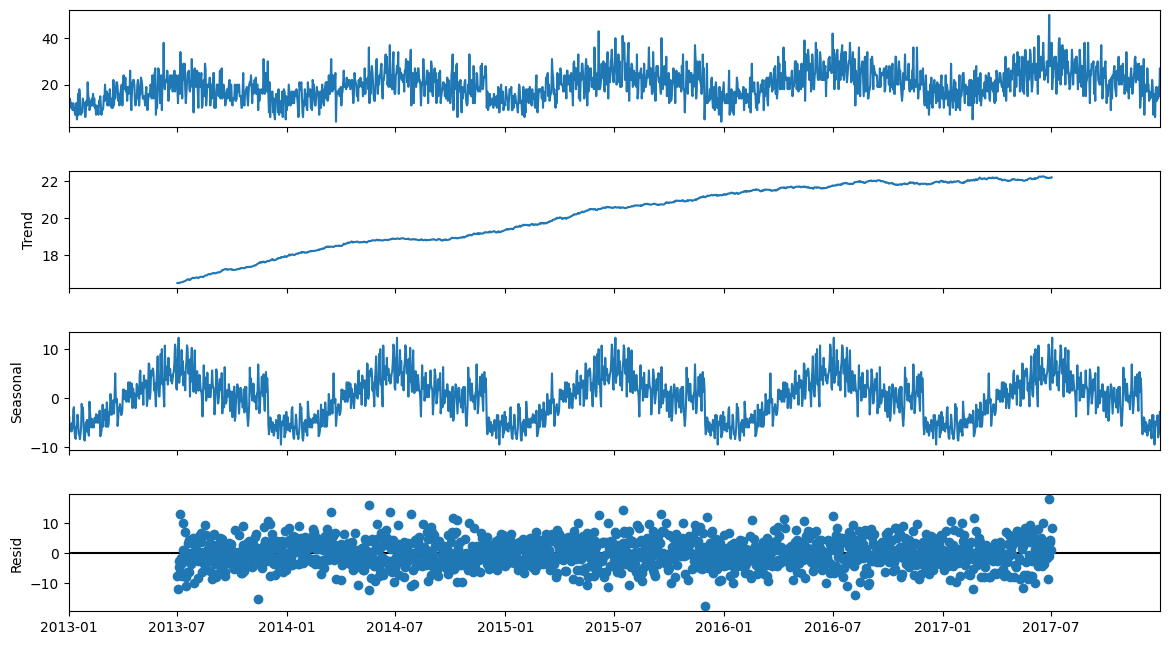

In [ ]:
decomposed = seasonal_decompose(df_one, model='additive', period=365)
fig = decomposed.plot()
fig.set_size_inches((12, 7))
plt.show()

By explicitly setting `period = 365`, `seasonal_decompose` reveals a clear yearly increasing trend.

## 4. `TimeSeries` in `darts`
Зі створеної підмножини даних в попередньому пункті створіть обʼєкт класу `TimeSeries` в `darts` лише для колонки `sales`.

In [ ]:
darts_series = TimeSeries.from_dataframe(df_one, value_cols='sales')

In [ ]:
darts_series

<TimeSeries (DataArray) (date: 1826, component: 1, sample: 1)> Size: 15kB
array([[[13.]],

       [[11.]],

       [[14.]],

       ...,

       [[15.]],

       [[27.]],

       [[23.]]])
Coordinates:
  * date       (date) datetime64[ns] 15kB 2013-01-01 2013-01-02 ... 2017-12-31
  * component  (component) object 8B 'sales'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

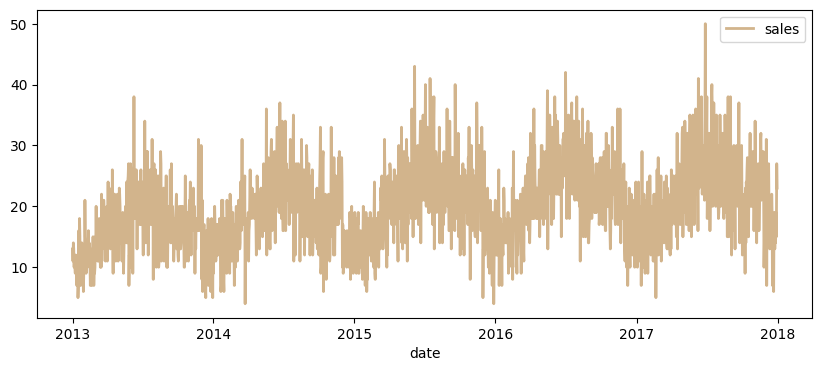

In [ ]:
darts_series.plot(color='tan')
plt.show()

## 5. `series.split_before`
Використовуючи метод `series.split_before` розбийте дані на тренування і валідацію так, аби валідація починалась з `2017-10-01` включно.

  Візуалізуйте на одному графіку тренувальну і валідаційну частину як було показано в лекції.

In [ ]:
train_series, val_series = darts_series.split_before(pd.Timestamp('2017-10-01'))

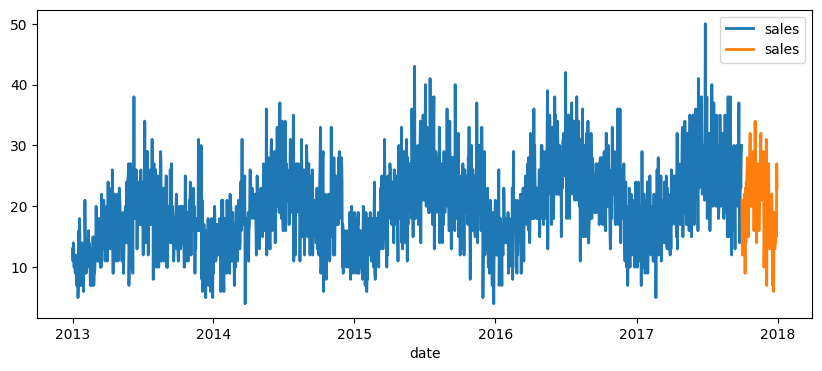

In [ ]:
plt.figure(figsize=(10, 4))
train_series.plot()
val_series.plot()
plt.show()

## 6. Partial autocorrelation
Побудуйте часткову автокореляційну функцію для цього нашого ряду в `series`. Напишіть висновки - які лаги є важливими для прогнозування?

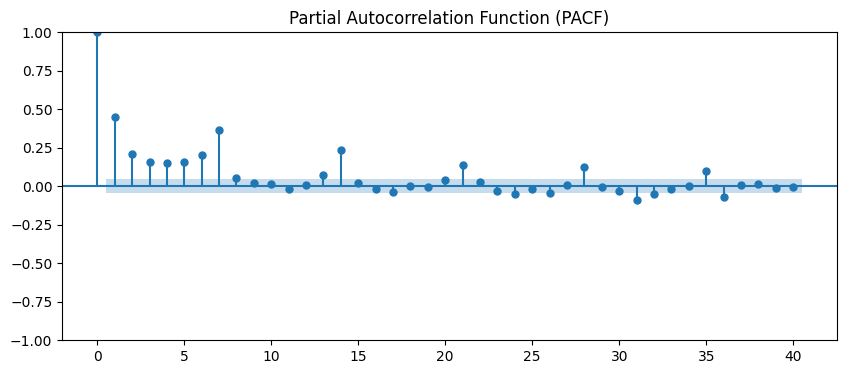

In [ ]:
plot_pacf(df_one,
          lags=40,
          method='ywm',
          title='Partial Autocorrelation Function (PACF)')
plt.show()

For forecasting, lags 1, 7, and 14 are important, highlighting the presence of weekly seasonality.

## 7. Seasonality
Виявіть сезональність тренувального ряду використовуючи функцію `check_seasonality` з `darts`.

In [ ]:
for m in range (2, 32):
    is_seasonal, period = check_seasonality(train_series, m=m, max_lag=32)
    if is_seasonal:
        print(f"There is seasonality of order {period}")

There is seasonality of order 7
There is seasonality of order 14
There is seasonality of order 21
There is seasonality of order 28


These results confirm our assumption of weekly seasonality.

Let's perform the Augmented Dickey-Fuller (ADF) test to check if the series is stationary.

In [ ]:
result = adfuller(df_one['sales'], regression='ct')
print(f'ADF Statistic: {result[0]:.3f}')
print(f'p-value: {result[1]:.4f}')
print('Critical Values:')
for key, value in result[4].items():
    print(f'\t{key}: {value:.3f}')

ADF Statistic: -3.243
p-value: 0.0761
Critical Values:
	1%: -3.964
	5%: -3.413
	10%: -3.128


The `p-value = 0.076`  is greater than the 0.05 significance level.
This means we fail to reject the null hypothesis, which suggests that the time series is not stationary (it has a trend or seasonality).
The presence of a trend is expected because we mentioned that sales tend to increase over time.

In [ ]:
adf_test = adfuller(df_one['sales'].diff().dropna(), regression='c')
print(f'ADF Statistic: {adf_test[0]:.3f}')
print(f'p-value: {adf_test[1]:.4f}')

ADF Statistic: -12.677
p-value: 0.0000


p-value lower than 0.05. Our series is now stationary.

## 8. NaiveSeasonal + NaiveDrift
Побудуйте наївну модель NaiveSeasonal + NaiveDrift для прогнозування даних. Кількість кроків для прогнозування визначить зі свого аналізу в попередніх пунктах. Візуалізуйте передбачення проти справжніх даних так, аби було видно якість передбачень. Зробіть висновок про модель. Вона точна?

  Якщо у вас є ідеї, як поліпшити якість передбачення саме наївними моделями - реалізуйте їх в цьому пункті :)

In [ ]:
seasonal_model = NaiveSeasonal(K=7)
seasonal_model.fit(train_series)
seasonal_forecast = seasonal_model.predict(len(val_series))

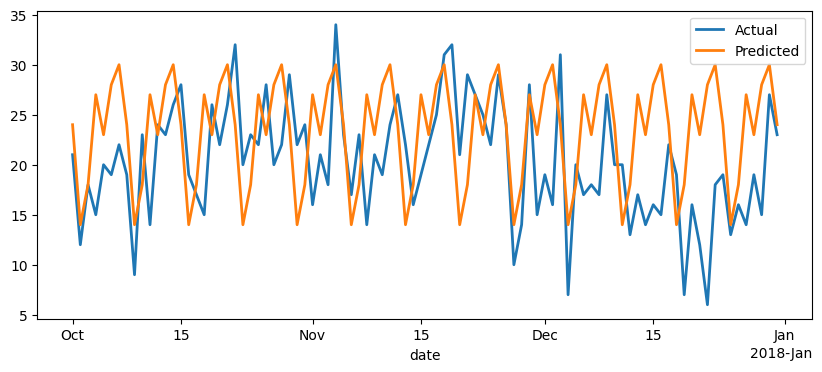

In [ ]:
val_series.plot(label='Actual')
seasonal_forecast.plot(label='Predicted')
plt.show()

In [ ]:
drift_model = NaiveDrift()
drift_model.fit(train_series)
drift_forecast = drift_model.predict(len(val_series))

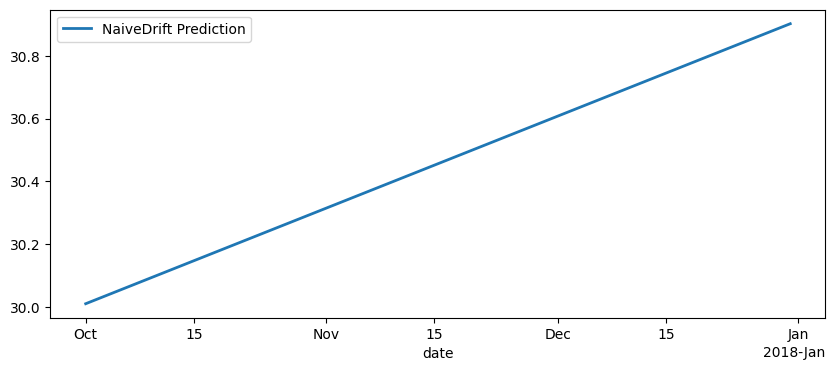

In [ ]:
drift_forecast.plot(label='NaiveDrift Prediction')
plt.show()

`NaiveDrift` shows an increase in sales over the evaluation period by approximately 1.

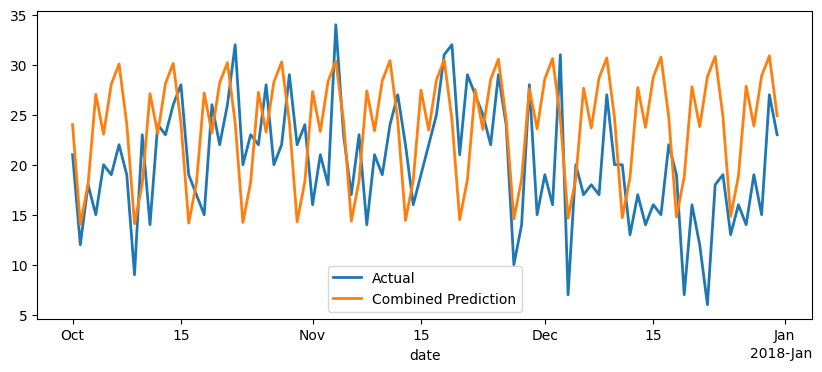

In [ ]:
combined_forecast = drift_forecast + seasonal_forecast - train_series.last_value()

val_series.plot(label='Actual')
combined_forecast.plot(label='Combined Prediction')
plt.show()

This model catch weekly seasonality, but not account for monthly variations.

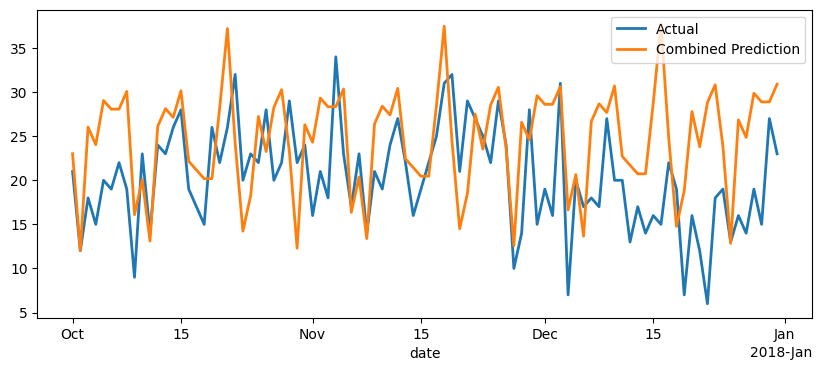

In [ ]:
seasonal_model_28 = NaiveSeasonal(K=28)
seasonal_model_28.fit(train_series)
seasonal_forecast_28 = seasonal_model_28.predict(len(val_series))

combined_forecast_28 = drift_forecast + seasonal_forecast_28 - train_series.last_value()

val_series.plot(label='Actual')
combined_forecast_28.plot(label='Combined Prediction')
plt.show()

It's look like `NaiveSeasonal` perform better with `K = 28`.

Let's combine the seasonal forecasts with `K = 7` and `K = 28` by averaging their predictions.

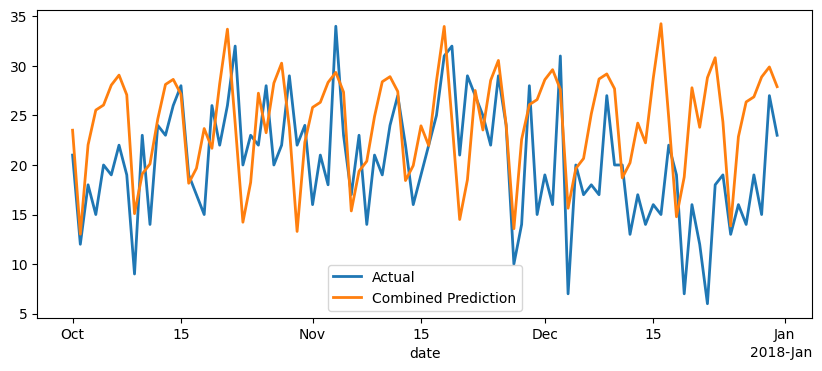

In [ ]:
combined_forecast_avg = (drift_forecast
                         + (seasonal_forecast + seasonal_forecast_28)/2
                         - train_series.last_value())

val_series.plot(label='Actual')
combined_forecast_avg.plot(label='Combined Prediction')
plt.show()

## 9. Error of predictions (MAPE)
Обчисліть помилку прогнозу на валідації наївною моделлю з mape. Далі для всіх моделей необхідно обчислювати помилку прогнозу на валідації.

In [ ]:
combined_mape = mape(val_series, combined_forecast)
print(f"MAPE for the combined naive drift + seasonal: {combined_mape:.2f}%.")

MAPE for the combined naive drift + seasonal: 39.91%.


In [ ]:
combined_avg_mape = mape(val_series, combined_forecast_avg)
print(f"MAPE for the combined naive drift + averaging seasonal 7 and 28: {combined_avg_mape:.2f}%.")

MAPE for the combined naive drift + averaging seasonal 7 and 28: 38.74%.


Averaging seasonal forecasts with periods of 7 and 28 slightly improve the results.

## 10. XBGModel from `darts`
Натренуйте XBGModel з `darts` для передбачення наших даних. Можна додавати всі додаткові ознаки, які вважаєте за потрібне, наприклад, ознаки з дати. Зробіть висновок про якість моделі.

In [ ]:
def fit_eval_plot(model, train, val):
    model.fit(train)
    forecast = model.predict(len(val))
    mape_ = mape(val, forecast)
    print(f"model {str(model).split('(')[0]} obtains MAPE: {mape_:.2f}%")

    val.plot(label='Actual')
    forecast.plot(label='Forecast')
    plt.legend()
    plt.show()

model XGBRegressor obtains MAPE: 37.51%


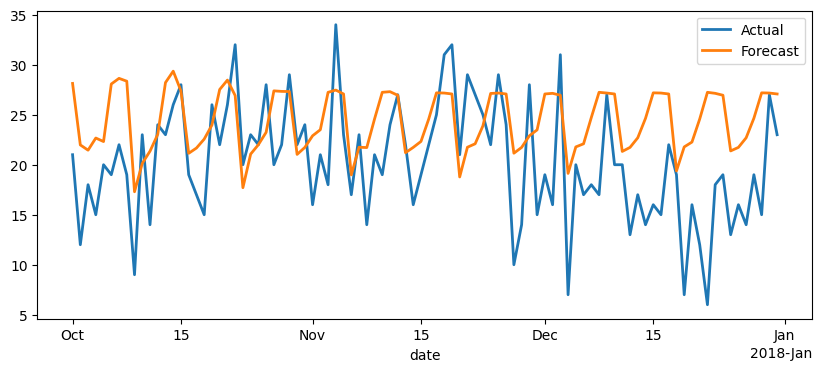

In [ ]:
model_xgb = XGBModel(
    lags=28,
    output_chunk_length=1,
    n_estimators=100,
    max_depth=4,
    learning_rate=0.03,
    random_state=42,
)

fit_eval_plot(model_xgb, train_series, val_series)

In [ ]:
def enrich_with_date_features(df):
    df['day_of_week'] = df['date'].dt.dayofweek
    df['month'] = df['date'].dt.month
    df['quarter'] = df['date'].dt.quarter
    df['year'] = df['date'].dt.year
    df['day_of_year'] = df['date'].dt.dayofyear
    df['day_of_month'] = df['date'].dt.day
    df['day_of_month_sin'] = np.sin(df['day_of_month']*(2*np.pi/31))
    df['day_of_month_cos'] = np.cos(df['day_of_month']*(2*np.pi/31))
    df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)
    return df

In [ ]:
def transform_time_series(time_series):
    time_series_df = time_series.pd_dataframe().reset_index()
    transformed_df = enrich_with_date_features(time_series_df)
    return TimeSeries.from_dataframe(transformed_df, time_col='date')

In [ ]:
def transform_fit_eval_plot(model, train_series, val_series):
    train_transformed = transform_time_series(train_series)
    scaler = Scaler()
    train_transformed_scaled = scaler.fit_transform(train_transformed)
    model.fit(train_transformed_scaled)
    forecast = scaler.inverse_transform(model.predict(len(val_series)))
    mape_ = mape(val_series['sales'], forecast['sales'])
    print(f"MAPE: {mape_:.2f}%")
    val_series['sales'].plot(label='Actual')
    forecast['sales'].plot(label='Forecast')
    plt.legend()
    plt.show()

MAPE: 24.71%


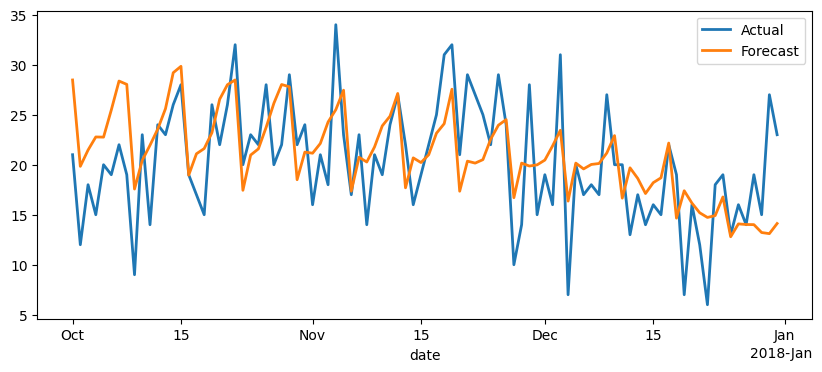

In [ ]:
transform_fit_eval_plot(model_xgb, train_series, val_series)

Adding additional generated features from the date significantly improved the model's performance.

## 11. ExponentialSmoothing
Натренуйте модель ExponentialSmoothing та зробіть висновок про її якість.

model ExponentialSmoothing obtains MAPE: 39.01%


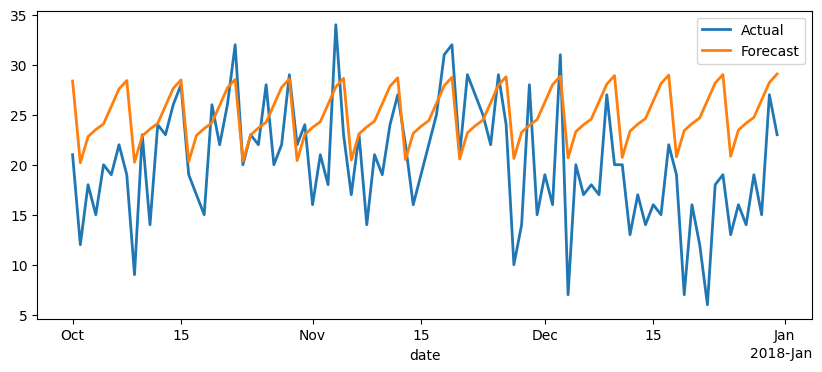

In [ ]:
fit_eval_plot(ExponentialSmoothing(), train_series, val_series)

`ExponentialSmoothing` slightly better than NaiveSeasonal + NaiveDrift.

## 12. ARIMA
Натренуйте модель ARIMA, параметри оберіть самостійно. Зробіть висновок про її якість.

model ARIMA obtains MAPE: 39.68%


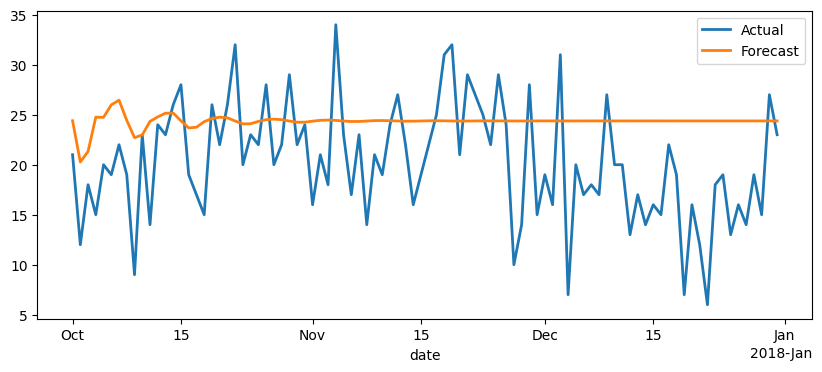

In [ ]:
model_arima = ARIMA(p=7, d=1, q=0)
fit_eval_plot(model_arima, train_series, val_series)

model ARIMA obtains MAPE: 37.30%


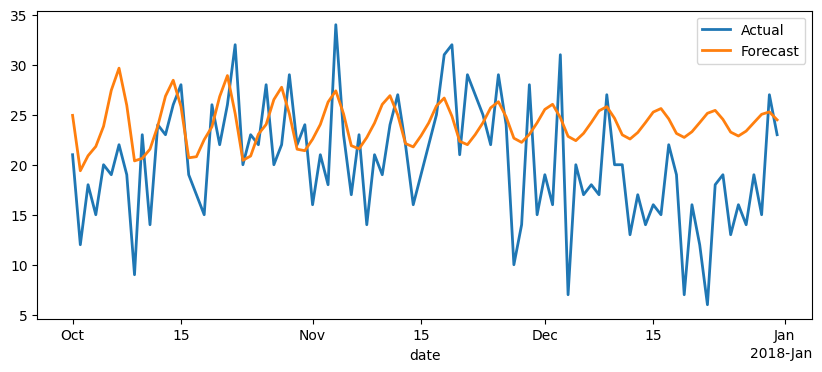

In [ ]:
model_arima = ARIMA(p=28, d=1, q=0)
fit_eval_plot(model_arima, train_series, val_series)

`ARIMA` with `p = 28` perform better than `ExponentialSmoothing` and similar to `XGBModel` without additional features.

model ARIMA obtains MAPE: 38.86%


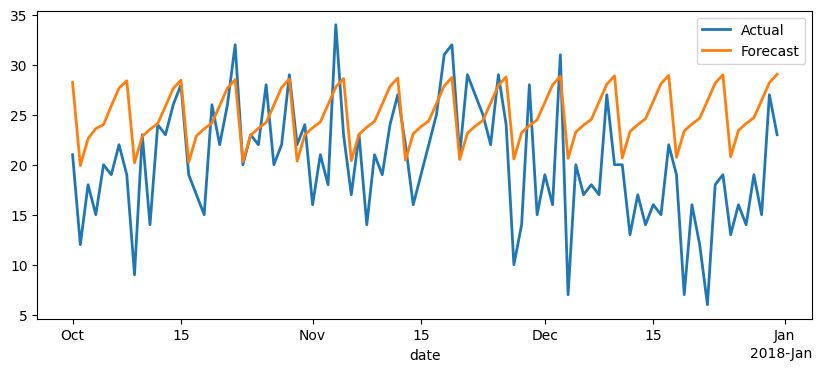

In [ ]:
model_arima = ARIMA(p=1, d=1, q=1, seasonal_order=(1, 1, 1, 7))
fit_eval_plot(model_arima, train_series, val_series)

model ARIMA obtains MAPE: 38.36%


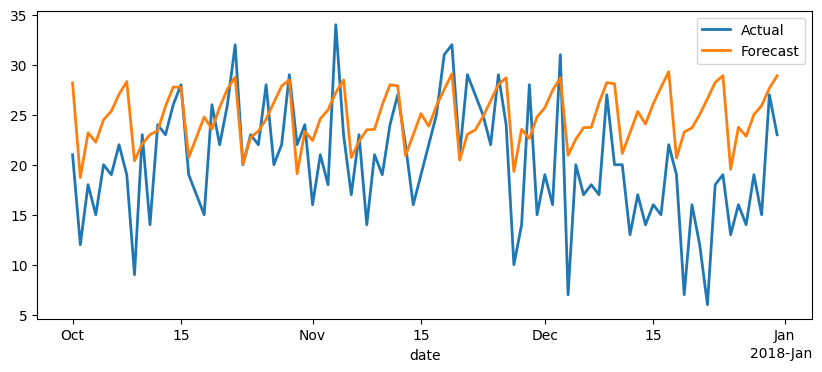

In [ ]:
model_arima = ARIMA(p=1, d=1, q=1, seasonal_order=(1, 1, 1, 28))
fit_eval_plot(model_arima, train_series, val_series)

## 13. AutoARIMA
Знайдіть оптимальні параметри моделі ARIMA з допомогою AutoARIMA моделі. Виконайте пошук параметрів, виведіть, які параметри виявились оптимальними і обчисліть якість моделі. Чи поліпшилась якість порівняно з попереднім експериментом?

model AutoARIMA obtains MAPE: 39.53%


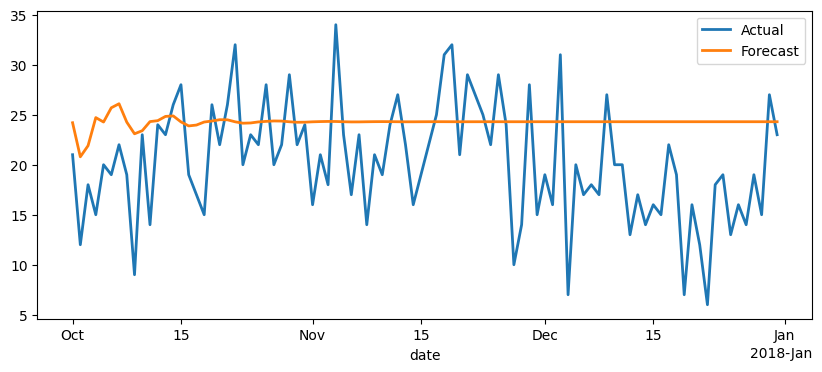

In [ ]:
model_autoARIMA = AutoARIMA(start_p=1, max_p=31, start_q=0)
fit_eval_plot(model_autoARIMA, train_series, val_series)

In [ ]:
model_autoARIMA.model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1734
Model:               SARIMAX(7, 1, 1)   Log Likelihood               -5286.539
Date:                Thu, 06 Mar 2025   AIC                          10591.078
Time:                        09:24:25   BIC                          10640.196
Sample:                             0   HQIC                         10609.244
                               - 1734                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0346      0.038      0.904      0.366      -0.040       0.109
ar.L2         -0.0799      0.034     -2.379      0.017      -0.146      -0.014
ar.L3         -0.0775      0.033     -2.316      0.021      -0.143      -0.012
ar.L4         -0.0651      0.034     -1.939      0.053      -0.131       0.001
ar.L5         -0.0342      0.032     -1.063      0.288      -0.097       0.029
ar.L6          0.0062      0.030      0.207      0.836      -0.053       0.065
ar.L7          0.2638      0.029      9.042      0.000       0.207       0.321
ma.L1         -0.9071      0.026    -34.233      0.000      -0.959      -0.855
sigma2        26.0956      0.820     31.811      0.000      24.488      27.703
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                16.19
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               1.39   Skew:                             0.15
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.37
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

`AutoARIMA` selected a`SARIMAX(7, 1, 1)` model, but it performed worse than an `ARIMA` model with manual tuned parameters. This suggests that automatic selection may not always yield the best results, and manual parameter tuning can lead to better performance.

### SARIMAX with Multiplicative Seasonal Components

#### 1. Adding duplicate series with different seasonality

##### `ARIMA` with exogenous variables

In [ ]:
def get_exog(ts):
    weekdays = pd.get_dummies(ts.time_index.dayofweek,
                          prefix='weekday',
                          dtype='int')
    yearly = pd.DataFrame({
    'sin_year': np.sin(2 * np.pi * ts.time_index.dayofyear / 365),
    'cos_year': np.cos(2 * np.pi * ts.time_index.dayofyear / 365)
    })
    exog_df = pd.concat([weekdays, yearly], axis=1)
    exog_df.set_index(ts.time_index, inplace=True)
    return exog_df

In [ ]:
exog_train_df = get_exog(train_series)
exog_val_df = get_exog(val_series)

In [ ]:
exog_train_series = TimeSeries.from_dataframe(exog_train_df)
exog_val_series = TimeSeries.from_dataframe(exog_val_df)

In [ ]:
def eval_polt(val, forecast):
    mape_ = mape(val_series, forecast)
    print(f"MAPE: {mape_:.2f}%")
    val_series.plot(label='Actual')
    forecast.plot(label='Forecast')
    plt.legend()
    plt.show()

MAPE: 24.49%


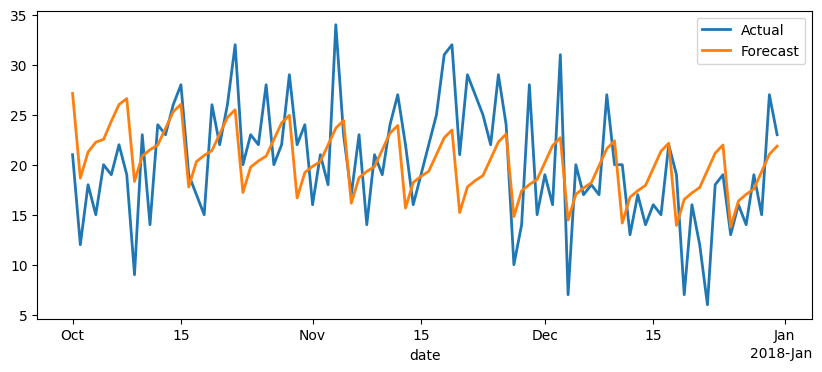

In [ ]:
model_arima_exog = ARIMA(1, 1, 1, seasonal_order=(1, 1, 1, 7))
model_arima_exog.fit(train_series, future_covariates=exog_train_series)

forecast = model_arima_exog.predict(len(val_series), future_covariates=exog_val_series)

eval_polt(val_series, forecast)

The best result!

##### `SARIMAX` from `statsmodels`

In [ ]:
train_df = train_series.pd_dataframe()
val_df = val_series.pd_dataframe()

In [ ]:
model_sarimax_exog = SARIMAX(train_df,
                             exog=exog_train_df)

result = model_sarimax_exog.fit()

pred = result.forecast(len(val_df), exog=exog_val_df)
mape_ = mean_absolute_percentage_error(val_df, pred)
print(f"Mape: {mape_*100:.2f}%")

Mape: 23.43%


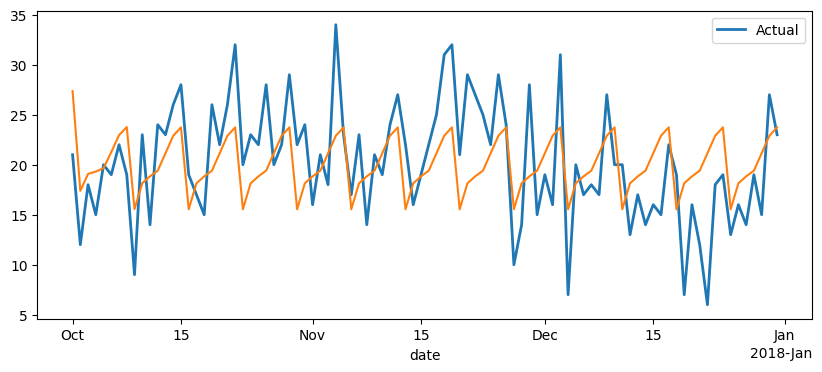

In [ ]:
val_series.plot(label='Actual')
plt.plot(pred, label='Forecast')
plt.show()

Slightly better than `ARIMA` with `future_covariates` and `seasonal_order`

#### 2. SARIMAX with annual seasonality and days of the week as exogenous variables

In [ ]:
weekdays_train = pd.get_dummies(train_series.time_index.dayofweek,
                                prefix='weekday',
                                dtype='int').set_index(train_series.time_index)

weekdays_val = pd.get_dummies(val_series.time_index.dayofweek,
                              prefix='weekday',
                              dtype='int').set_index(val_series.time_index)

model_sarimax_exog_weekdays = SARIMAX(train_df,
                                      exog=weekdays_train,
                                      seasonal_order=(0, 0, 0, 365))

result = model_sarimax_exog_weekdays.fit()

pred = result.forecast(len(val_df), exog=weekdays_val)
mape_ = mean_absolute_percentage_error(val_df, pred)
print(f"Mape: {mape_*100:.2f}%")

Mape: 26.03%


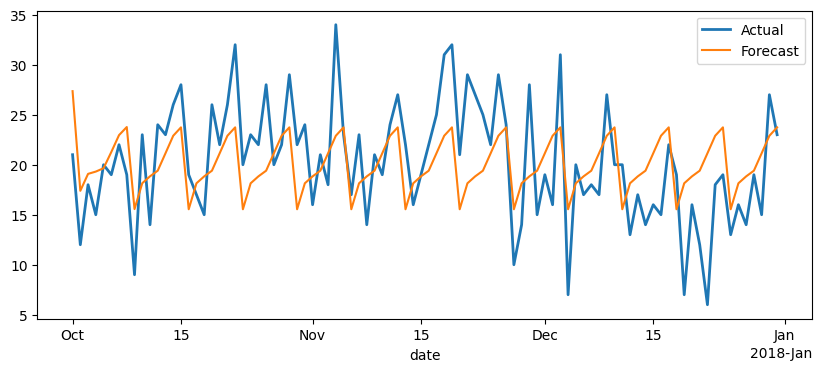

In [ ]:
val_series.plot(label='Actual')
plt.plot(pred, label='Forecast')
plt.legend()
plt.show()

## 14. Prophet
Натренуйте модель Prophet та зробіть висновок про її якість.

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model Prophet obtains MAPE: 23.80%


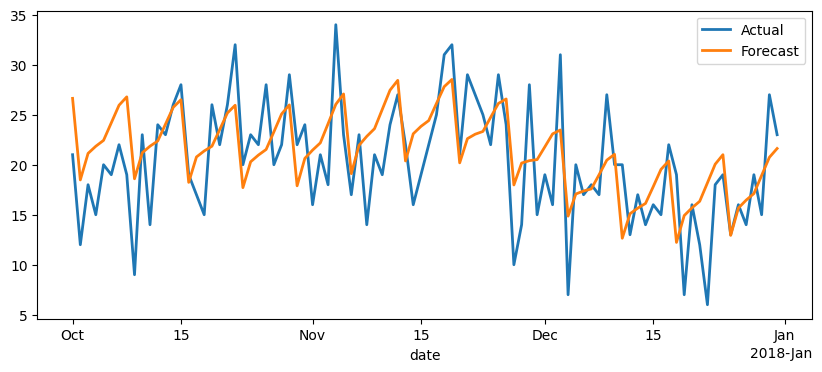

In [ ]:
model_prophet = Prophet()

fit_eval_plot(model_prophet, train_series, val_series)

The `Prophet` model with default parameters performs better than earlier tested models, exept for `SARIMAX` from `statsmodels`.

Let's add exogenous variables.

MAPE: 23.81%


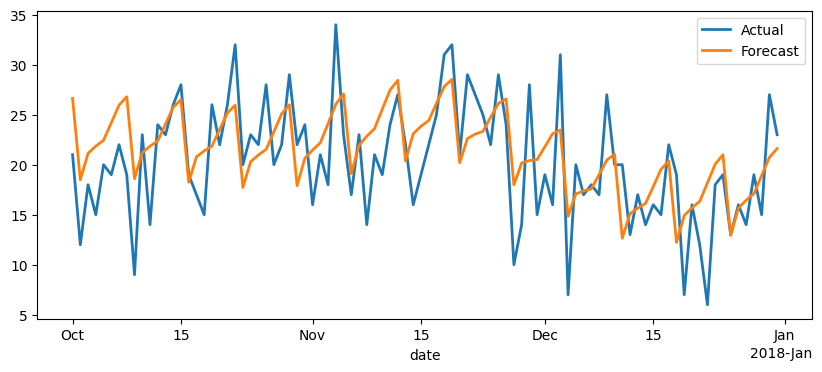

In [ ]:
exog_ts = TimeSeries.from_dataframe(get_exog(darts_series))
model_prophet = Prophet(daily_seasonality=True, weekly_seasonality=True, yearly_seasonality=True)

model_prophet.fit(train_series, future_covariates=exog_ts)
forecast = model_prophet.predict(len(val_series), future_covariates=exog_ts)
mape_ = mape(val_series, forecast)
print(f"MAPE: {mape_:.2f}%")

val_series.plot(label='Actual')
forecast.plot(label='Forecast')
plt.legend()
plt.show()

Adding these `future_covariates` didn't improve the model's performance.

Let's try add future covariates, that can be automatically generated with add_encoders.

model Prophet obtains MAPE: 22.49%


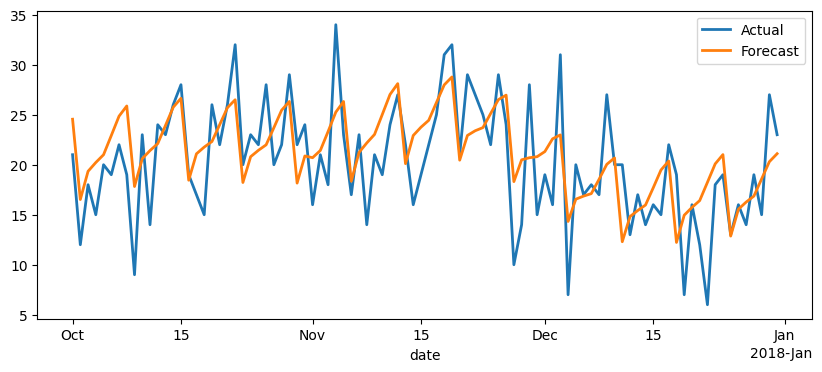

In [ ]:
add_encoders={
    'cyclic': {'future': ['day', 'month', 'quarter', 'day_of_year', 'day_of_week']},
    'datetime_attribute': {'future': ['month', 'day', 'week', 'day_of_year', ]},
    'position': {'future': ['relative']},
    'transformer': Scaler(),
}

model_prophet = Prophet(daily_seasonality=True,
                        weekly_seasonality=True,
                        yearly_seasonality=True,
                        add_encoders=add_encoders)

fit_eval_plot(model_prophet, train_series, val_series)

In [ ]:
prophet_forecast = model_prophet.predict(len(val_series))
prophet_rmse = rmse(val_series, prophet_forecast)
print(f"RMSE: {prophet_rmse:.2f}")

RMSE: 4.44


The new best result!

## 15. RNNModel
Натренуйте модель `RNNModel` та зробіть висновок про її якість.

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 2.8 K  | train
6 | V               | Linear           | 26     | train
-------------------------------------------------------------
2.8 K     Trainable params
0         Non-trainable p

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

model RNNModel obtains MAPE: 29.44%


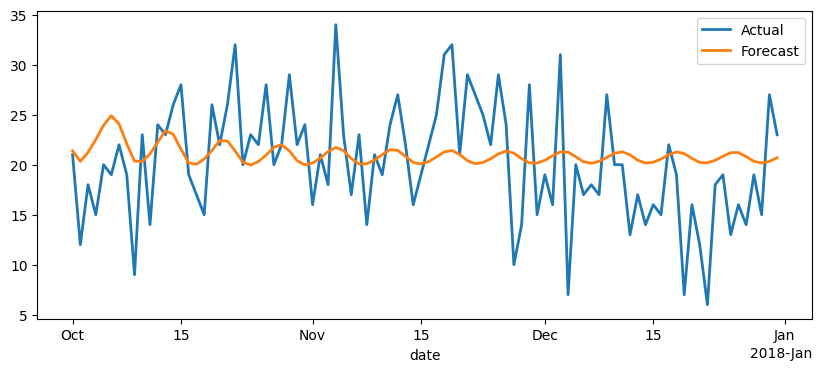

In [ ]:
model_rnn = RNNModel(input_chunk_length=7, model='LSTM', n_epochs=100)
fit_eval_plot(model_rnn, train_series, val_series)

Not too bad by MAPE score, but looking at the plot, this is a poor model.

Let's add additional features generated from the date and scaler features.

In [ ]:
scaler = Scaler()

train_scaled = scaler.fit_transform(train_series)
val_scaled = scaler.transform(val_series)
series_scaler = scaler.transform(darts_series)

In [ ]:
year_series = datetime_attribute_timeseries(
    pd.date_range(start=darts_series.start_time(),
                  end=darts_series.end_time(),
                  freq=darts_series.freq_str),
    attribute='year',
    one_hot=False
)

year_series = Scaler().fit_transform(year_series)

month_series = datetime_attribute_timeseries(
    year_series,
    attribute='month',
    one_hot=True,
)

week_series = datetime_attribute_timeseries(
    year_series,
    attribute='week',
   cyclic=True,
)

day_of_year = datetime_attribute_timeseries(
    year_series,
    attribute='day_of_year',
    cyclic=True,
)


day_of_week = datetime_attribute_timeseries(
    year_series,
    attribute='day_of_week',
    cyclic=True,
)

covariates = concatenate([year_series, month_series, week_series, day_of_year, day_of_week], axis=1)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | eval 
1 | train_criterion | MSELoss          | 0      | eval 
2 | val_criterion   | MSELoss          | 0      | eval 
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 3.4 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
3.4 K     Trainable params
0         Non-trainable p

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=75` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

model RNNModel obtains MAPE: 24.15%


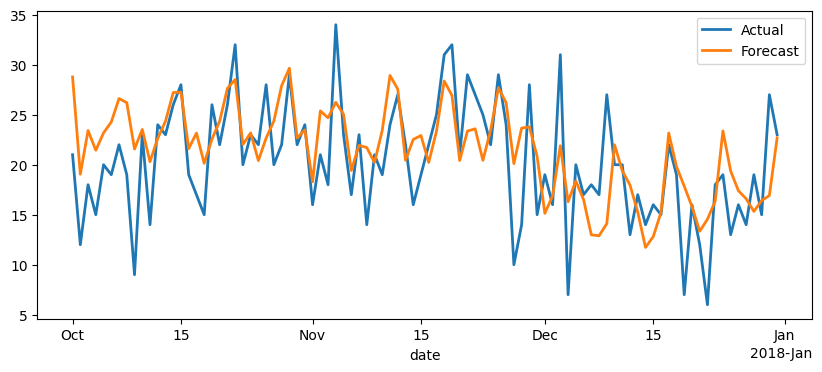

In [ ]:
model_RNN = RNNModel(
    input_chunk_length=7,
    model='LSTM',
    hidden_dim=20,
    batch_size=16,
    n_epochs=75,
    optimizer_kwargs={'lr': 0.001},
    random_state=42,
    training_length=21,
)

model_RNN.fit(train_scaled,
          future_covariates=covariates,
          val_series=val_scaled,
          val_future_covariates=covariates,
          verbose=True)

RNN_forecast = scaler.inverse_transform(model_RNN.predict(len(val_series)))

mape_ = mape(val_series, RNN_forecast)
print(f"model {str(model_RNN).split('(')[0]} obtains MAPE: {mape_:.2f}%")

val_series.plot(label='Actual')
RNN_forecast.plot(label='Forecast')
plt.legend()
plt.show()

This model catch varying of sales.

In [ ]:
rmse_ = rmse(val_series, RNN_forecast)
print(f"RMSE: {rmse_:.2f}")

RMSE: 4.87


## 16. Backtesting
Виконайте бектест для тої моделі, яка виявилась найкращою у вашому дослідженні на періоді 1 рік з передбаченнями на 1 місяць щоразу. Візуалізуйте як поводилась модель протягом бектесту, яка була точність?

`RNNModel` and `Prophet` achieved similar performance. However, since `RNNModel` is more computationally expensive, the `Prophet` model is preffered for development.

In [ ]:
add_encoders={
    'cyclic': {'future': ['day', 'month', 'quarter', 'day_of_year', 'day_of_week']},
    'datetime_attribute': {'future': ['month', 'day', 'week', 'day_of_year', ]},
    'position': {'future': ['relative']},
    'transformer': Scaler(),
}

model_prophet = Prophet(daily_seasonality=True,
                        weekly_seasonality=True,
                        yearly_seasonality=True,
                        add_encoders=add_encoders)

model_prophet.fit(train_series)
prophet_forecast = model_prophet.predict(len(val_series))
mape_ = mape(val_series, prophet_forecast)
print(f"MAPE: {mape_:.2f}%")

MAPE: 22.49%


historical forecasts: 100%|██████████| 92/92 [00:32<00:00,  2.80it/s]


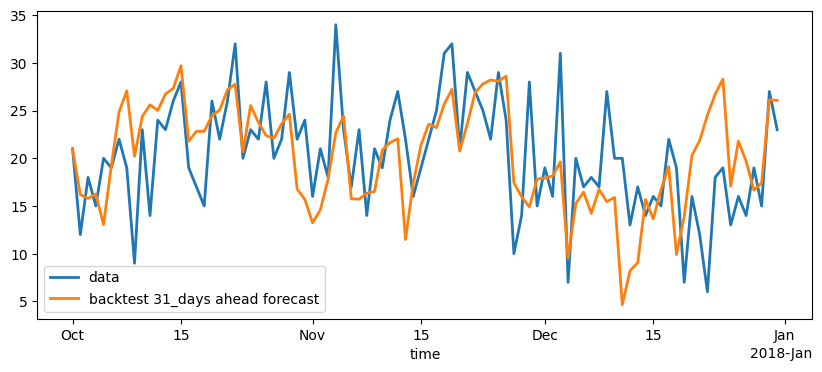

MAPE: 26.62%


In [ ]:
hfc_params = {
    'series': darts_series,
    'start': pd.Timestamp('2017-09-01'),
    'forecast_horizon': 31,
    'train_length': 365,
    'verbose': True,
}

historical_fcast = model_prophet.historical_forecasts(last_points_only=True,
                                                      **hfc_params)

val_series.plot(label='data')
historical_fcast.plot(label='backtest 31_days ahead forecast')
plt.show()

print(f"MAPE: {mape(darts_series, historical_fcast):.2f}%")

This is pretty good result for this series.

historical forecasts: 100%|██████████| 92/92 [00:40<00:00,  2.30it/s]


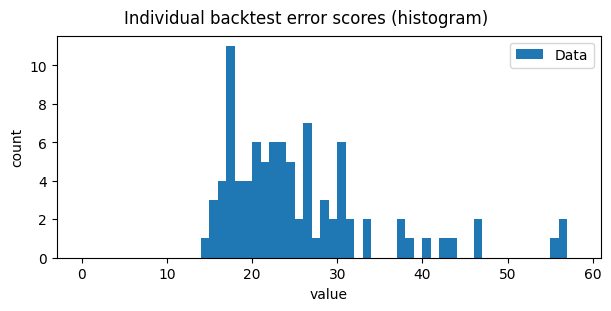

In [ ]:
raw_errors = model_prophet.backtest(metric=mape,
                                    reduction=None,
                                    last_points_only=False,
                                    **hfc_params)

plot_hist(
    raw_errors,
    bins=np.arange(0, max(raw_errors), 1),
    fig_size=(6, 3),
    title="Individual backtest error scores (histogram)",
)
plt.show()

In [ ]:
average_error = model_prophet.backtest(
    metric=mape,
    reduction=np.mean,  # this is actually the default
    **hfc_params
)

print(f"\nAverage error (MAPE) over all historical forecasts: {average_error:.2f}")

historical forecasts: 100%|██████████| 92/92 [00:35<00:00,  2.61it/s]


Average error (MAPE) over all historical forecasts: 25.88


There are no significant differences in MAPE between individual predictions and overall historical forecasts, which is a good result.

## 17. Conclusions


- In my opinion, the `Prophet` model is preffered for development. However, in this case, to predict sales for the next month for each of the 50 items in each of the 10 stores, we need train 50*10 models in a loop.
- Alternatively, we could use Global Forecasting Models from Darts, which support training on multiple series. These include PyTorch-based models (RNNModel, BlockRNNModel, TCNModel, TransformerModel, etc) or Regression Models (RandomForest, LightGBMModel, XGBModel, etc.). These models also support the use of covariates time series (time series of "external data").